Dataset URL: https://www.kaggle.com/datasets/vishakhdapat/customer-segmentation-clustering


In [17]:
import pandas as pd
import os
import numpy as np
import random
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import RobustScaler,OneHotEncoder,OrdinalEncoder
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.decomposition import PCA

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [18]:
df = pd.read_csv('./Dataset/customer_segmentation.csv')
print(f"Duplicates: {df.duplicated(subset=['ID']).sum()}")
print(df.shape)

df.head()

Duplicates: 0
(2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [19]:
df = df.drop(columns=['ID','Response','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Z_CostContact','Z_Revenue'],errors='ignore')
df.shape

(2240, 20)

In [20]:
df.loc[0]

Year_Birth                   1957
Education              Graduation
Marital_Status             Single
Income                    58138.0
Kidhome                         0
Teenhome                        0
Dt_Customer            04-09-2012
Recency                        58
MntWines                      635
MntFruits                      88
MntMeatProducts               546
MntFishProducts               172
MntSweetProducts               88
MntGoldProds                   88
NumDealsPurchases               3
NumWebPurchases                 8
NumCatalogPurchases            10
NumStorePurchases               4
NumWebVisitsMonth               7
Complain                        0
Name: 0, dtype: object

In [21]:
df.isna().sum()

Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Complain                0
dtype: int64

In [22]:
df['age'] = dt.now().year - df['Year_Birth']
df['month_cust'] = df['Dt_Customer'].apply(lambda x: 12*(relativedelta(dt.now(),pd.to_datetime(x, format='%d-%m-%Y')).years) + relativedelta(dt.now(),pd.to_datetime(x, format='%d-%m-%Y')).months)
df = df.drop(columns=['Year_Birth','Dt_Customer'])

In [23]:
cat_cols = []
num_cols = []

for i in df.columns:
    # print(str(df[i].dtype))
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        num_cols.append(i)
    else:
        cat_cols.append(i)

print(f'Categorical: {cat_cols}')
print(f'Numeric: {num_cols}')

Categorical: ['Education', 'Marital_Status']
Numeric: ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Complain', 'age', 'month_cust']


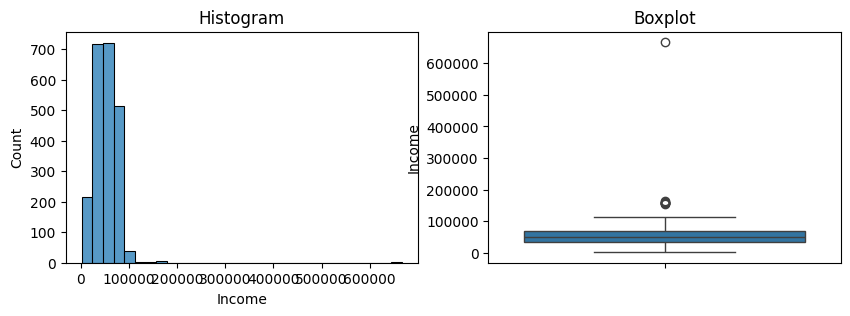

Skewness: 6.763487372811116
Kurtosis: 159.6366995778005


KeyboardInterrupt: 

In [24]:
def check_distribution_outliers(df, columns):
    for col in columns:
        plt.figure(figsize=(10, 3))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], bins=30)
        plt.title('Histogram')

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col])
        plt.title('Boxplot')

        plt.show()

        print('Skewness:', df[col].skew())
        print('Kurtosis:', df[col].kurt())

check_distribution_outliers(df[num_cols], num_cols)

In [70]:
temp_cols = ['Complain','Teenhome','Kidhome']
num_cols = [i for i in num_cols if i not in temp_cols]
num_cols, cat_cols, temp_cols

(['Income',
  'Recency',
  'MntWines',
  'MntFruits',
  'MntMeatProducts',
  'MntFishProducts',
  'MntSweetProducts',
  'MntGoldProds',
  'NumDealsPurchases',
  'NumWebPurchases',
  'NumCatalogPurchases',
  'NumStorePurchases',
  'NumWebVisitsMonth',
  'age',
  'month_cust'],
 ['Education', 'Marital_Status'],
 ['Complain', 'Teenhome', 'Kidhome'])

In [10]:
for i in cat_cols:
    print(df[i].value_counts(),'\n')

Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64 

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 



In [71]:
df = df[~df['Marital_Status'].isin(['Alone','Absurd','YOLO'])].reset_index(drop=True)

In [12]:
for i in cat_cols:
    print(df[i].value_counts(),'\n')

Education
Graduation    1125
PhD            483
Master         368
2n Cycle       203
Basic           54
Name: count, dtype: int64 

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Name: count, dtype: int64 



In [72]:
ord_enc = OrdinalEncoder(categories=[['Basic','Graduation','2n Cycle','Master','PhD']])
ohe_enc = OneHotEncoder(sparse_output=False)

In [73]:
oh_encoded = ohe_enc.fit_transform(df[['Marital_Status']])
one_hot_df = pd.DataFrame(oh_encoded, columns=ohe_enc.get_feature_names_out(['Marital_Status']))

In [74]:
df['Education'] = ord_enc.fit_transform(df[['Education']])
df = pd.concat([df.drop(columns=['Marital_Status']),one_hot_df.astype('int')],axis=1)
df.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumStorePurchases,NumWebVisitsMonth,Complain,age,month_cust,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
0,1.0,58138.0,0,0,58,635,88,546,172,88,...,4,7,0,67,147,0,0,1,0,0
1,1.0,46344.0,1,1,38,11,1,6,2,1,...,2,5,0,70,128,0,0,1,0,0
2,1.0,71613.0,0,0,26,426,49,127,111,21,...,10,4,0,59,135,0,0,0,1,0
3,1.0,26646.0,1,0,26,11,4,20,10,3,...,4,6,0,40,129,0,0,0,1,0
4,4.0,58293.0,1,0,94,173,43,118,46,27,...,6,5,0,43,130,0,1,0,0,0


In [75]:
df['Income'] = df['Income'].fillna(df['Income'].median())

In [76]:
rob_scaler = RobustScaler()
df[num_cols] = rob_scaler.fit_transform(df[num_cols])

In [18]:
df.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumStorePurchases,NumWebVisitsMonth,Complain,age,month_cust,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
0,1.0,0.205776,0,0,0.16,0.960499,2.50000,2.217593,3.404255,2.50000,...,-0.2,0.25,0,0.722222,1.000000,0,0,1,0,0
1,1.0,-0.153874,1,1,-0.24,-0.336798,-0.21875,-0.282407,-0.212766,-0.21875,...,-0.6,-0.25,0,0.888889,-0.727273,0,0,1,0,0
2,1.0,0.616686,0,0,-0.48,0.525988,1.28125,0.277778,2.106383,0.40625,...,1.0,-0.50,0,0.277778,-0.090909,0,0,0,1,0
3,1.0,-0.754551,1,0,-0.48,-0.336798,-0.12500,-0.217593,-0.042553,-0.15625,...,-0.2,0.00,0,-0.777778,-0.636364,0,0,0,1,0
4,4.0,0.210502,1,0,0.88,0.000000,1.09375,0.236111,0.723404,0.59375,...,0.2,-0.25,0,-0.611111,-0.545455,0,1,0,0,0


# Dimensionality Reduction

In [19]:
pca = PCA()
pca.fit(df)

PCA()

Text(0, 0.5, 'Eigenvalues')

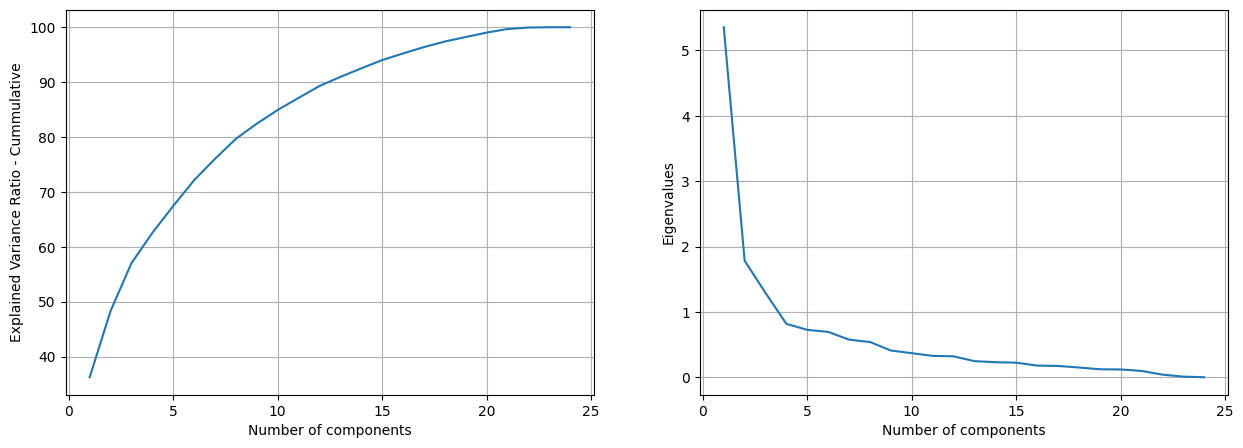

In [20]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.plot(range(1, len(df.columns)+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cummulative')

plt.subplot(1, 2, 2)
plt.grid()
plt.plot(range(1, len(df.columns)+1), pca.explained_variance_ )
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')

In [109]:
pca_comp = PCA(n_components=4)

df_pca = pca_comp.fit_transform(df)

In [110]:
df_pca

array([[ 4.49006822, -0.96456193,  0.57377499,  0.54366882],
       [-2.03934182, -1.00466376, -0.42422455, -0.21038538],
       [ 1.42567212, -0.85514059, -0.27498538, -0.53796504],
       ...,
       [ 0.59061015, -0.725068  , -0.60270274, -0.69428644],
       [ 1.25731755,  1.29852453,  0.03972497, -0.49915585],
       [-1.80937085,  1.90374005,  0.23337304,  0.35809256]])

# Clustering

In [26]:
distortions = []
silhouettes = []
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=SEED)
    cluster_label=kmeanModel.fit_predict(df_pca)
    #calculate silhouette_score for each cluster
    silhouette_avg = silhouette_score(df_pca, cluster_label)
    print(
        "For n_clusters =",k,
        "The average silhouette_score is :",silhouette_avg,
        )
    #kmeans inertia_ attribute is:  Sum of squared distances of samples #to their closest cluster center.
    distortions.append(kmeanModel.inertia_)
    silhouettes.append(silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.433814203434725
For n_clusters = 3 The average silhouette_score is : 0.33040668988654415
For n_clusters = 4 The average silhouette_score is : 0.34485526414197304
For n_clusters = 5 The average silhouette_score is : 0.34429285186789366
For n_clusters = 6 The average silhouette_score is : 0.35237933264573984
For n_clusters = 7 The average silhouette_score is : 0.3497905458861878
For n_clusters = 8 The average silhouette_score is : 0.34691362088162664
For n_clusters = 9 The average silhouette_score is : 0.34240739393789843


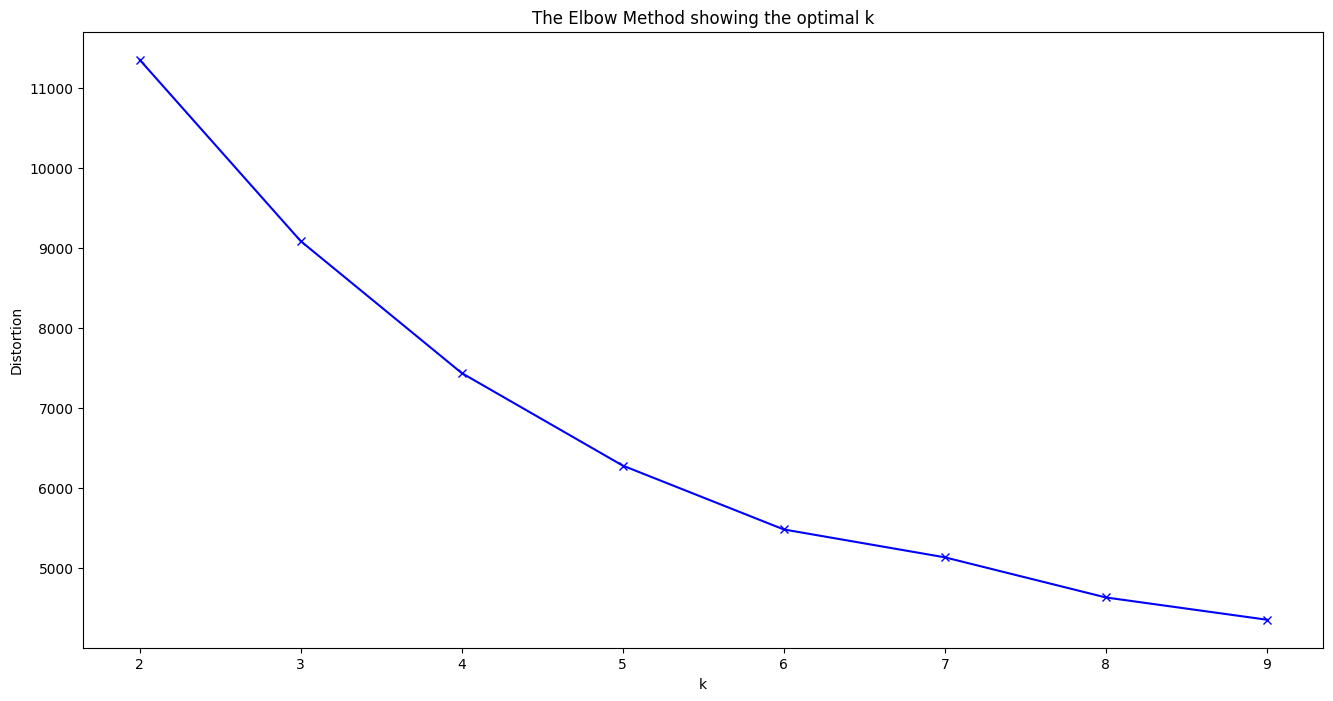

In [27]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.433814203434725
For n_clusters = 3 The average silhouette_score is : 0.33040668988654415
For n_clusters = 4 The average silhouette_score is : 0.34485526414197304
For n_clusters = 5 The average silhouette_score is : 0.34429285186789366
For n_clusters = 6 The average silhouette_score is : 0.35237933264573984
For n_clusters = 7 The average silhouette_score is : 0.3497905458861878
For n_clusters = 8 The average silhouette_score is : 0.34691362088162664
For n_clusters = 9 The average silhouette_score is : 0.34240739393789843


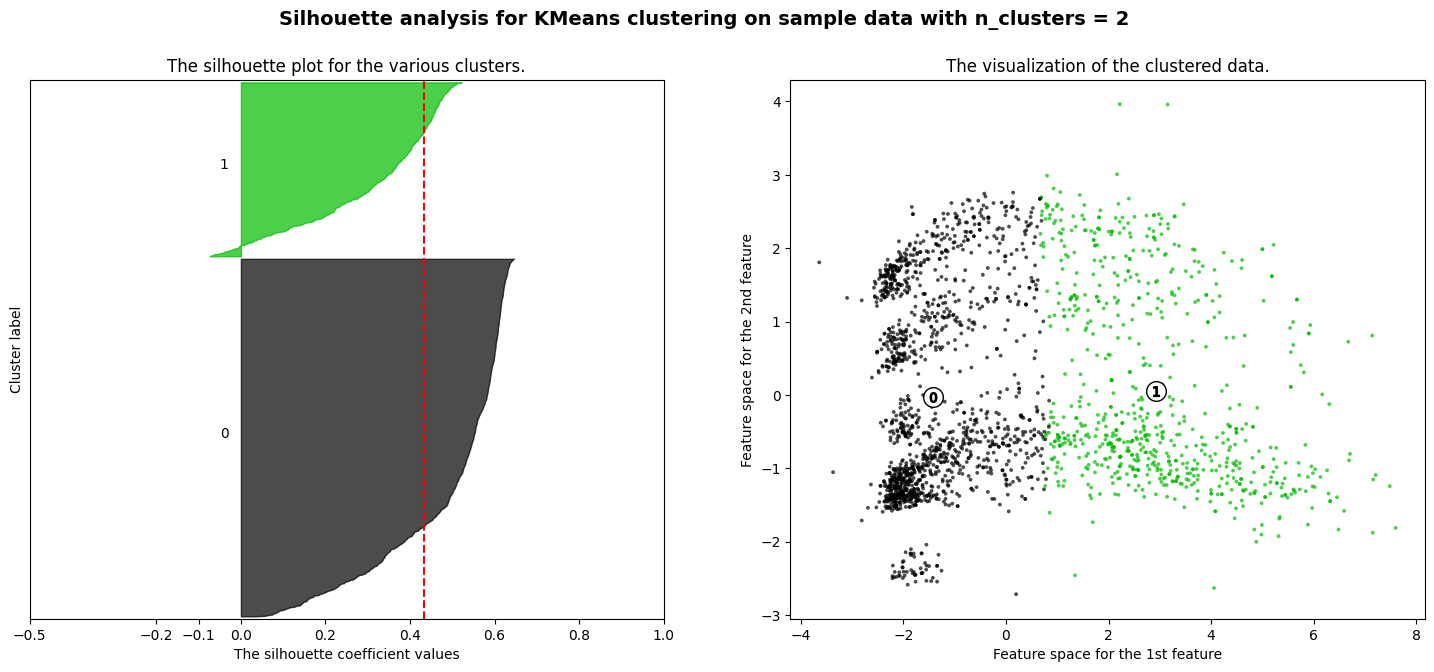

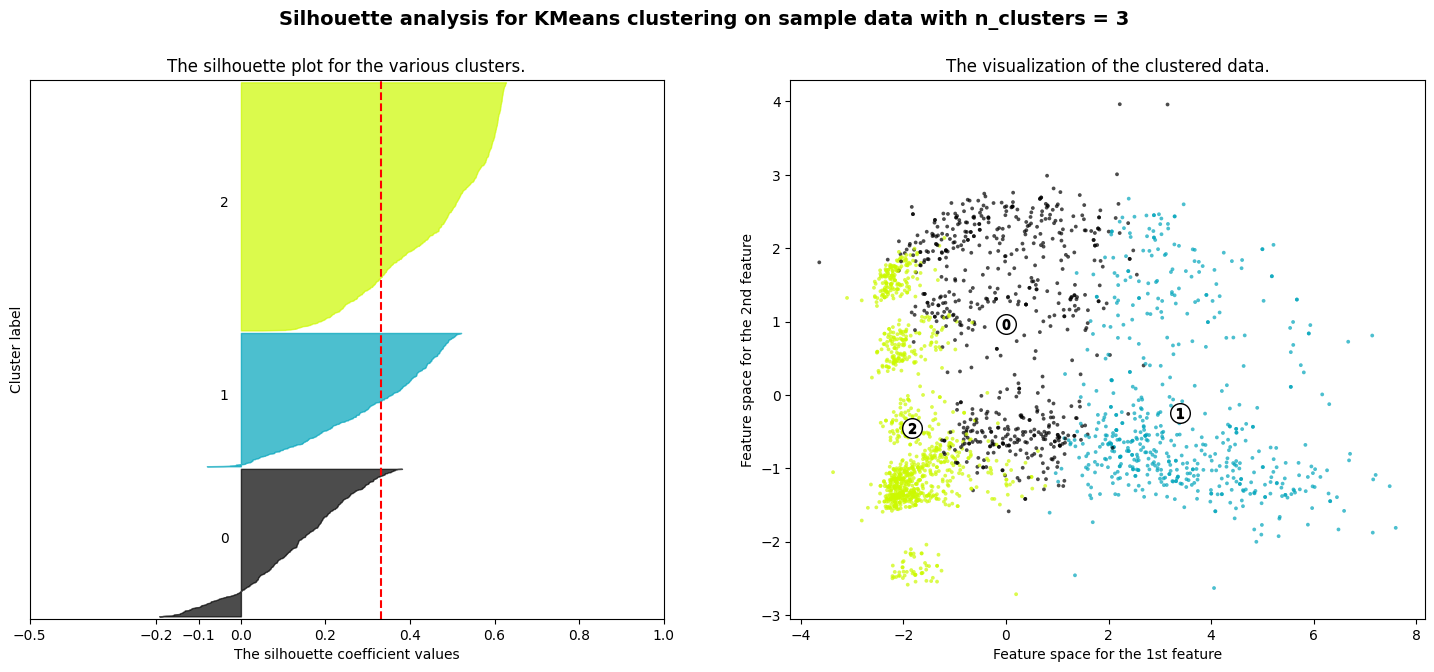

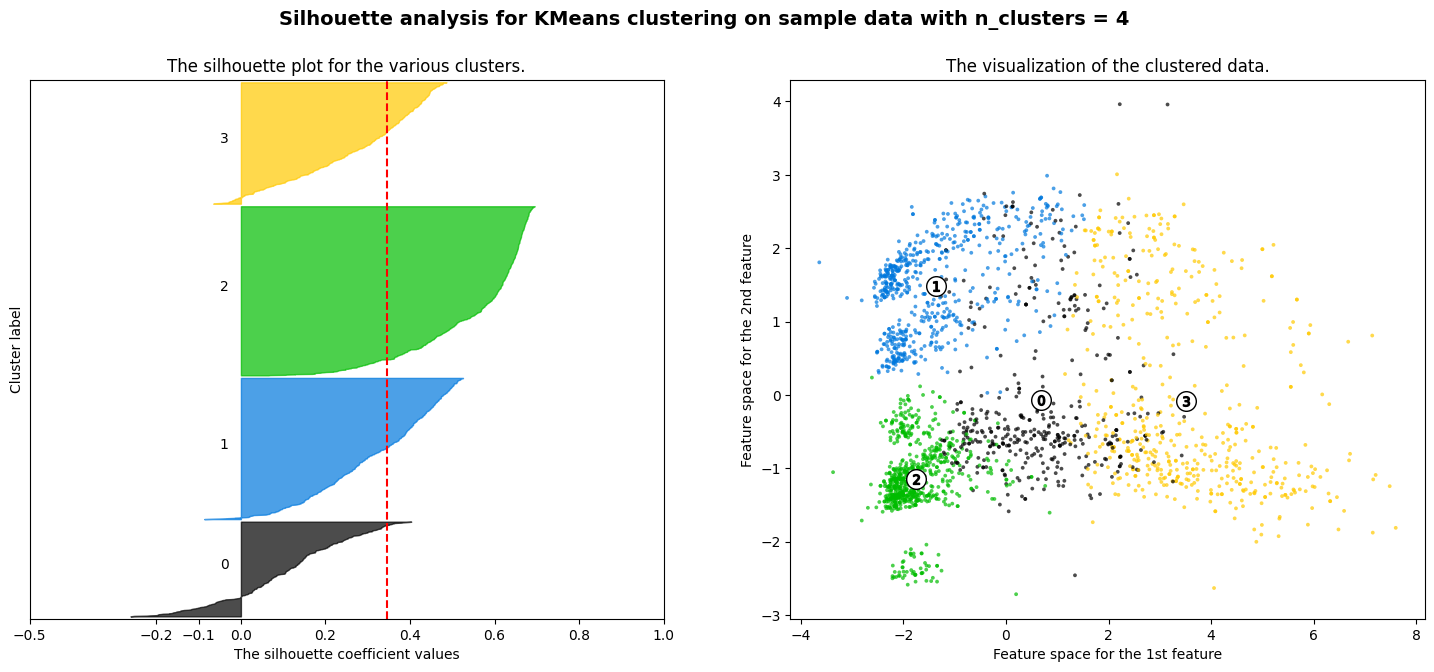

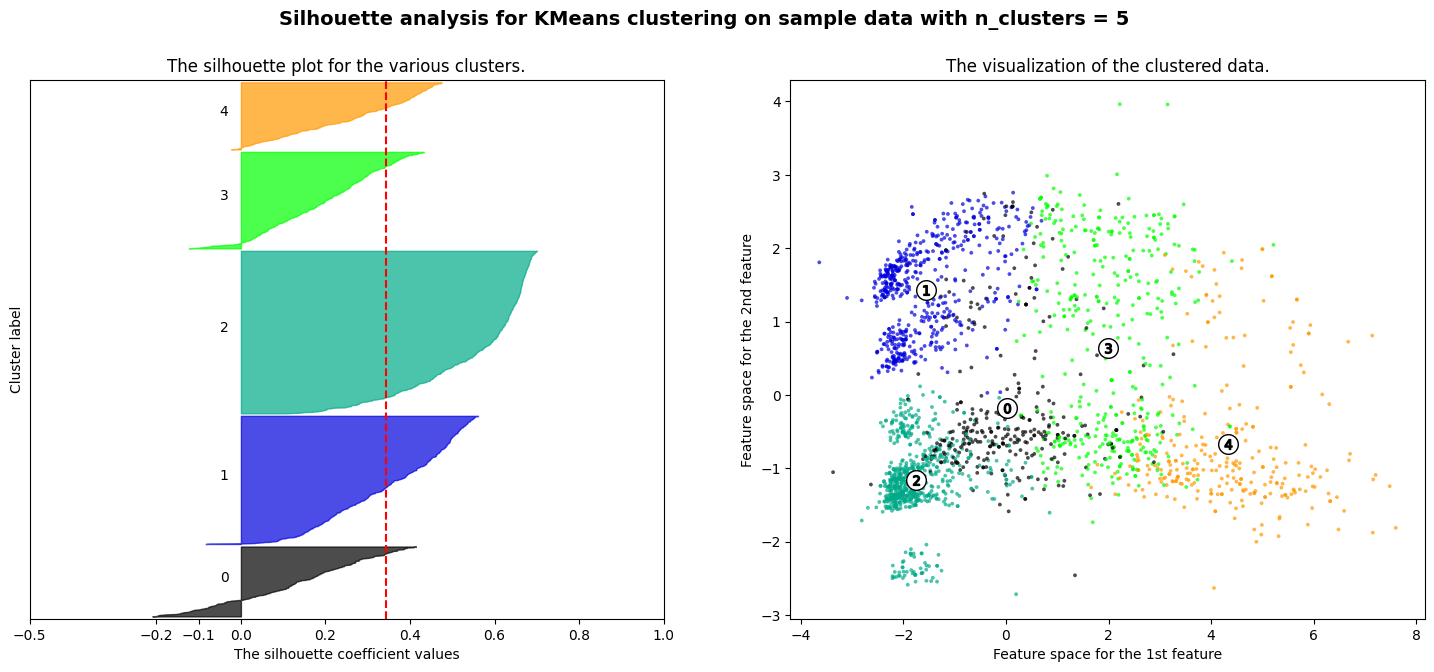

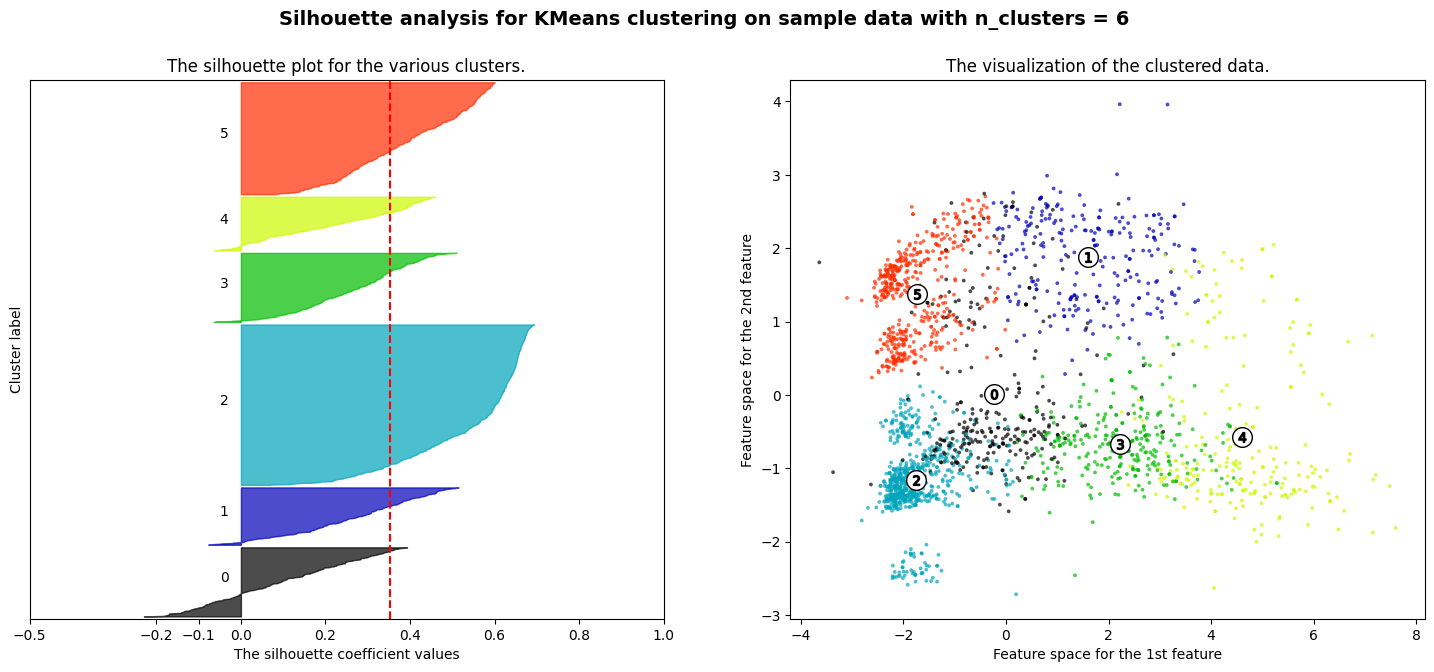

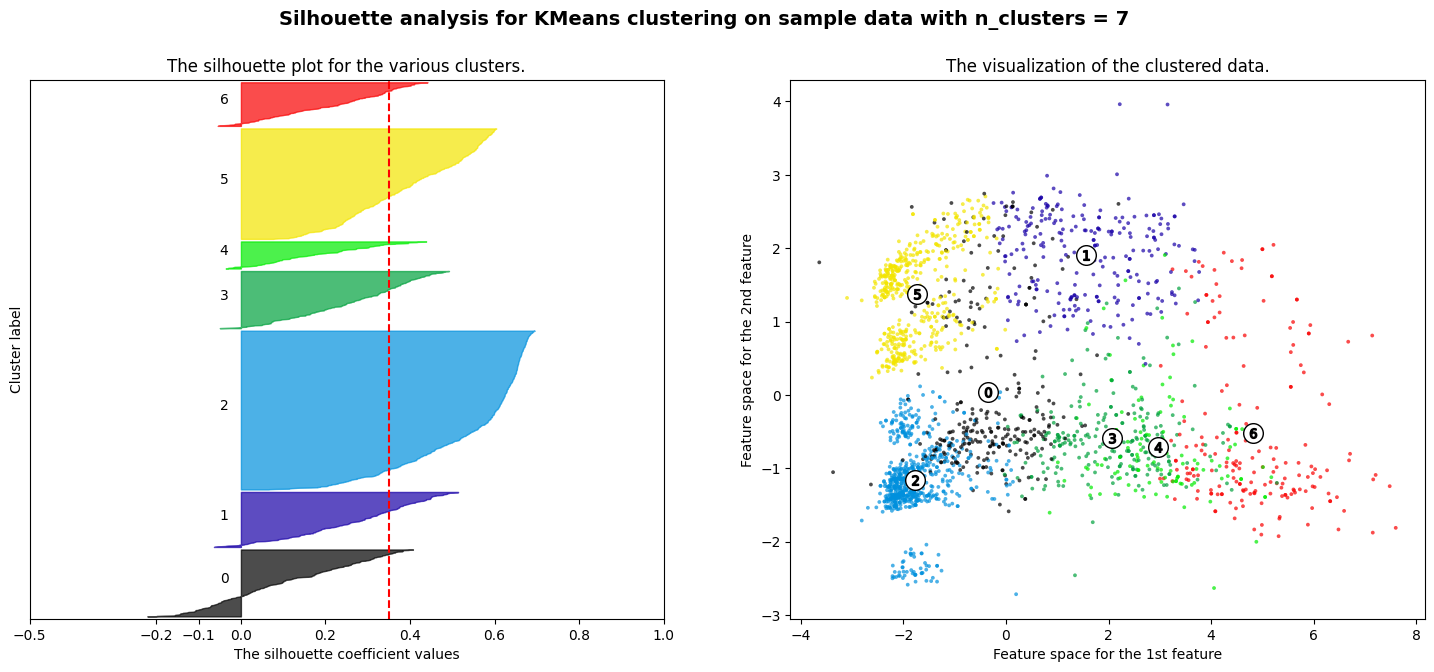

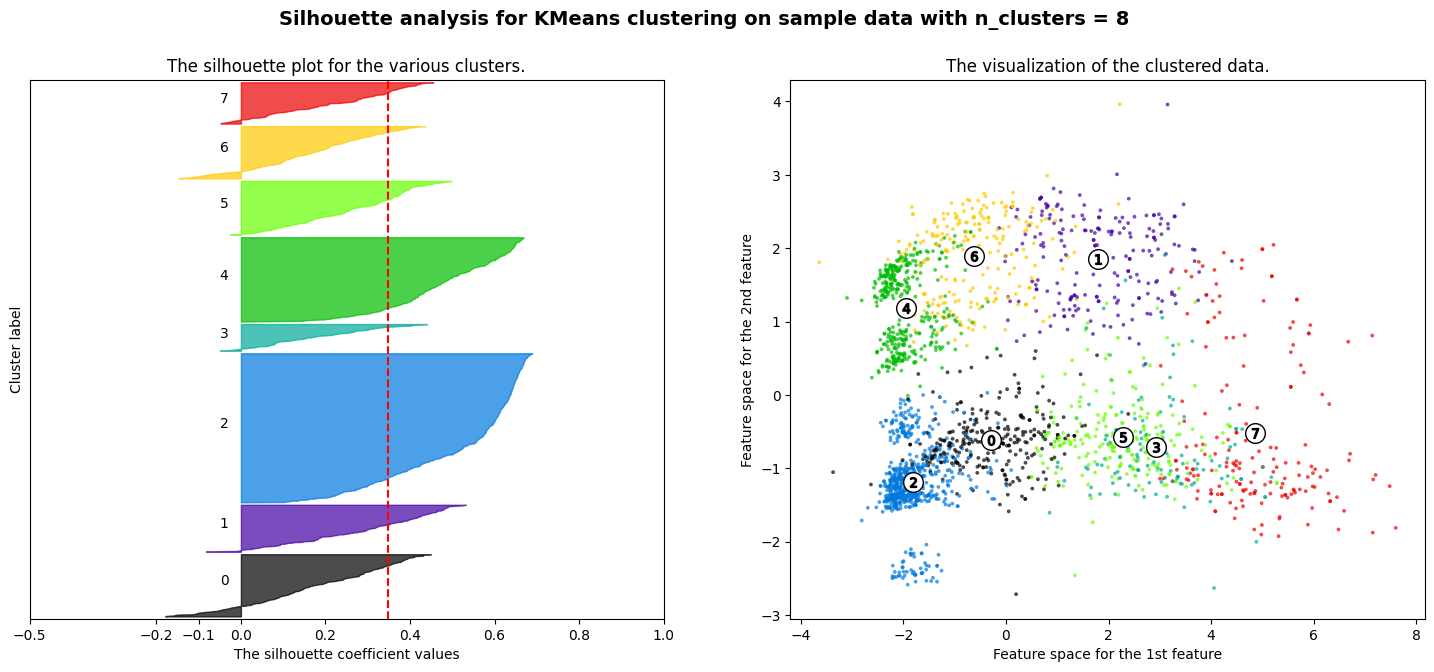

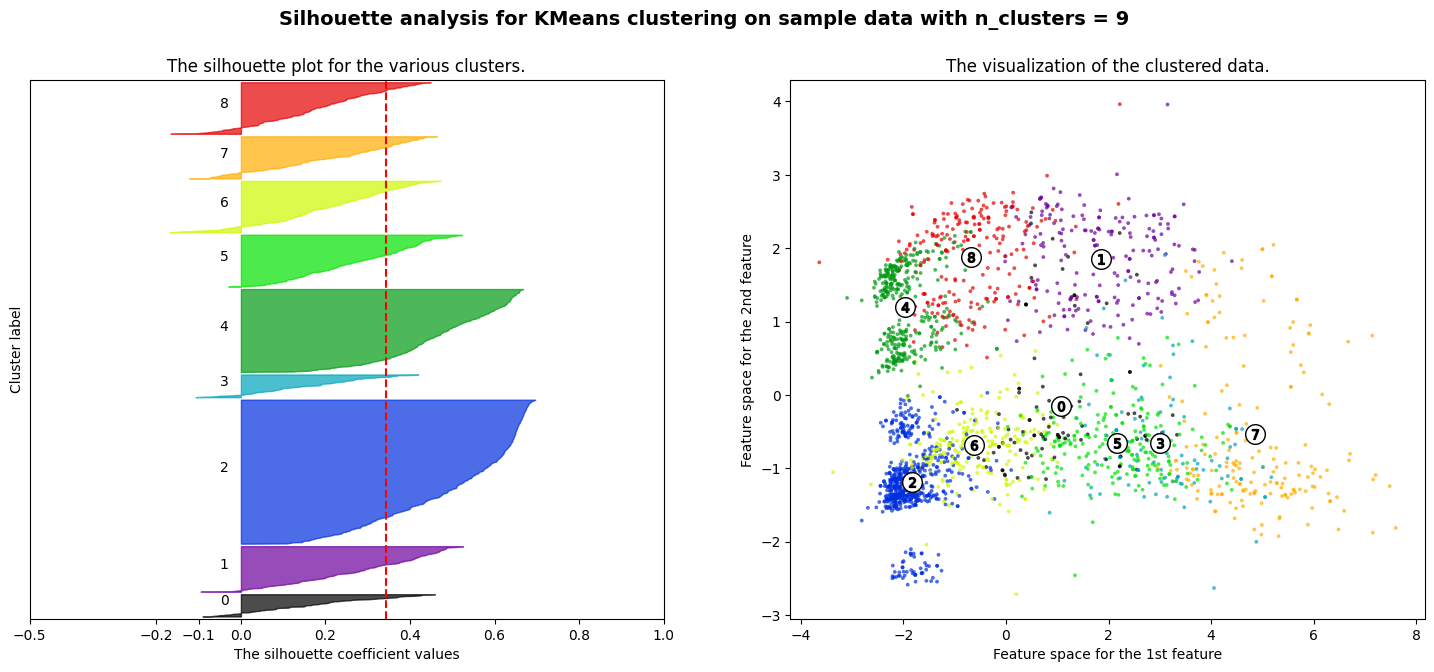

In [29]:
for n_clusters in K:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.5, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_pca) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=SEED)
    cluster_labels = clusterer.fit_predict(df_pca)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_pca, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.5,-0.2,-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    pca_comp = PCA(n_components=2)
    df_pca_2 = pca_comp.fit_transform(df)

    ax2.scatter(
        df_pca_2[:, 0], df_pca_2[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [77]:
model = KMeans(n_clusters = 3, random_state = SEED)
pred = model.fit_predict(df_pca)
df_kmeans = df.copy()
df_kmeans['cluster']=pred
pred

array([1, 2, 1, ..., 0, 0, 0])

In [78]:
df_kmeans

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumWebVisitsMonth,Complain,age,month_cust,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,cluster
0,1.0,0.205776,0,0,0.16,0.960499,2.50000,2.217593,3.404255,2.50000,...,0.25,0,0.722222,1.000000,0,0,1,0,0,1
1,1.0,-0.153874,1,1,-0.24,-0.336798,-0.21875,-0.282407,-0.212766,-0.21875,...,-0.25,0,0.888889,-0.727273,0,0,1,0,0,2
2,1.0,0.616686,0,0,-0.48,0.525988,1.28125,0.277778,2.106383,0.40625,...,-0.50,0,0.277778,-0.090909,0,0,0,1,0,1
3,1.0,-0.754551,1,0,-0.48,-0.336798,-0.12500,-0.217593,-0.042553,-0.15625,...,0.00,0,-0.777778,-0.636364,0,0,0,1,0,2
4,4.0,0.210502,1,0,0.88,0.000000,1.09375,0.236111,0.723404,0.59375,...,-0.25,0,-0.611111,-0.545455,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2228,1.0,0.299851,0,1,-0.08,1.114345,1.09375,0.532407,0.638298,3.43750,...,-0.25,0,0.166667,0.090909,0,1,0,0,0,1
2229,4.0,0.384960,2,1,0.12,0.484407,-0.25000,-0.171296,-0.255319,-0.25000,...,0.25,0,1.333333,-1.000000,0,0,0,1,0,0
2230,1.0,0.170494,0,0,0.82,1.528067,1.25000,0.694444,0.425532,0.12500,...,0.00,0,-0.611111,-0.545455,1,0,0,0,0,0
2231,3.0,0.544476,0,1,-0.84,0.530146,0.68750,0.680556,1.446809,0.68750,...,-0.75,0,0.777778,-0.545455,0,0,0,1,0,0


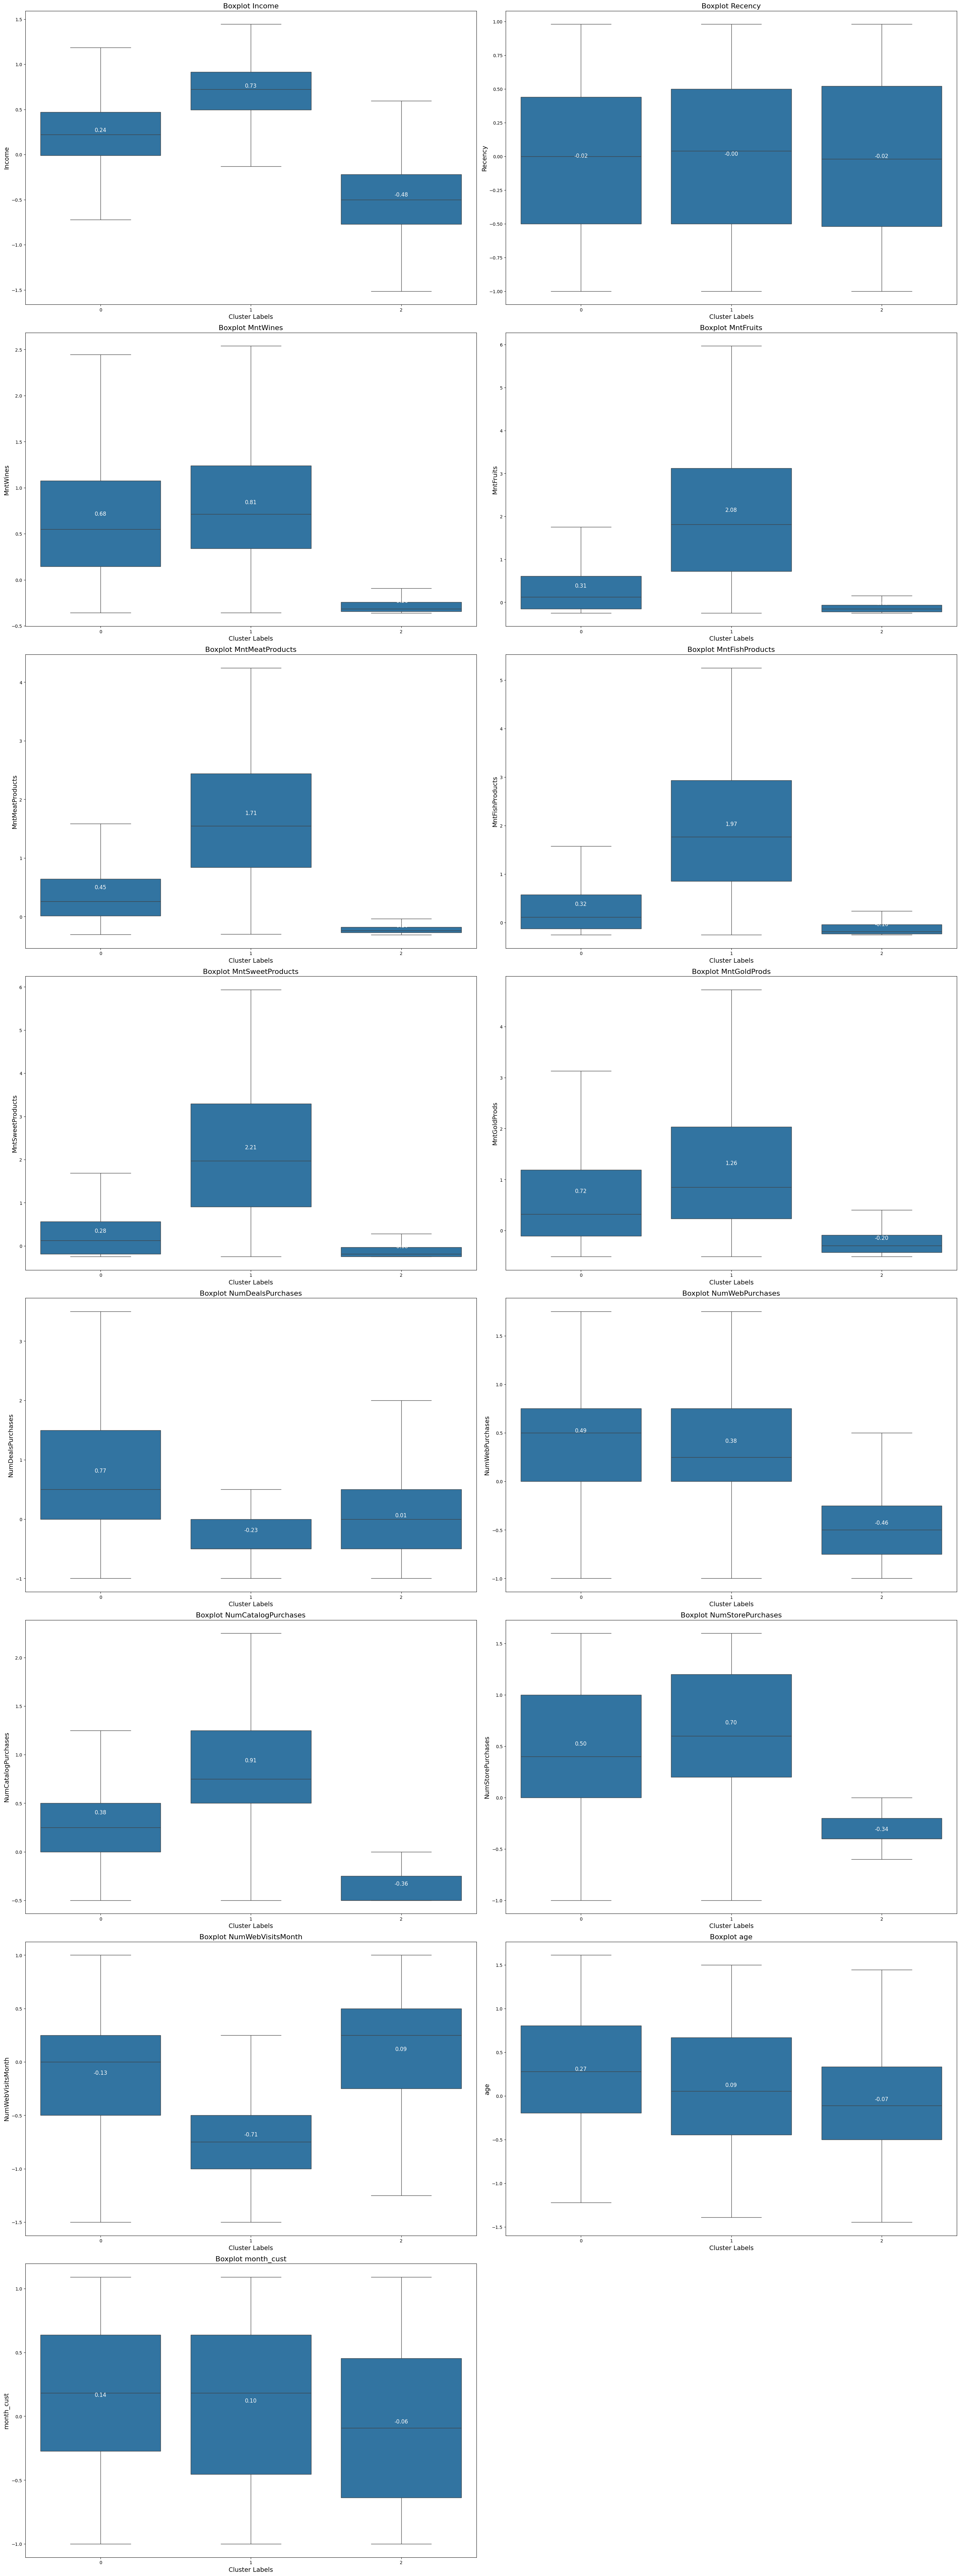

In [79]:
plt.figure(figsize=(30, 150))
for i, fitur in enumerate(num_cols, 1):
    plt.subplot(len(num_cols),2, i)
    sns.boxplot(x='cluster', y=fitur, data=df_kmeans, showfliers=False)  # Menghilangkan outliers dan menggunakan palet warna Set3
    plt.xlabel('Cluster Labels', fontsize=14)
    plt.ylabel(fitur, fontsize=14)
    plt.title(f'Boxplot {fitur}', fontsize=16)
    
    # Menambahkan garis rata-rata ke dalam boxplot
    means = df_kmeans.groupby('cluster')[fitur].mean().values
    for j, mean in enumerate(means):
        plt.text(j, mean, f'{mean:.2f}', ha='center', va='bottom', color='white', fontsize=12)

plt.tight_layout()
plt.show()

<Axes: >

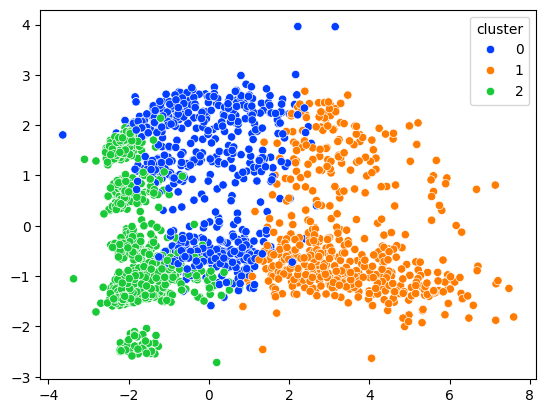

In [80]:
sns.scatterplot(x=df_pca[:,0], y=df_pca[:,1], hue=df_kmeans['cluster'], palette='bright')

In [81]:
df_kmeans['cluster'].value_counts()

cluster
2    1047
0     623
1     563
Name: count, dtype: int64

# DBSCAN

In [53]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [114]:
neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(df_pca)
distances, indices = nbrs.kneighbors(df_pca)
print(distances, indices)

[[0.         0.50945871 0.50945871]
 [0.         0.0656938  0.1050393 ]
 [0.         0.38037288 0.41395413]
 ...
 [0.         0.35960362 0.37356608]
 [0.         0.26450351 0.43339771]
 [0.         0.34072807 0.36063299]] [[   0 2161 1811]
 [   1 2120 1938]
 [   2 1993 1564]
 ...
 [2230  163  496]
 [2231  559 1003]
 [2232  851 1033]]


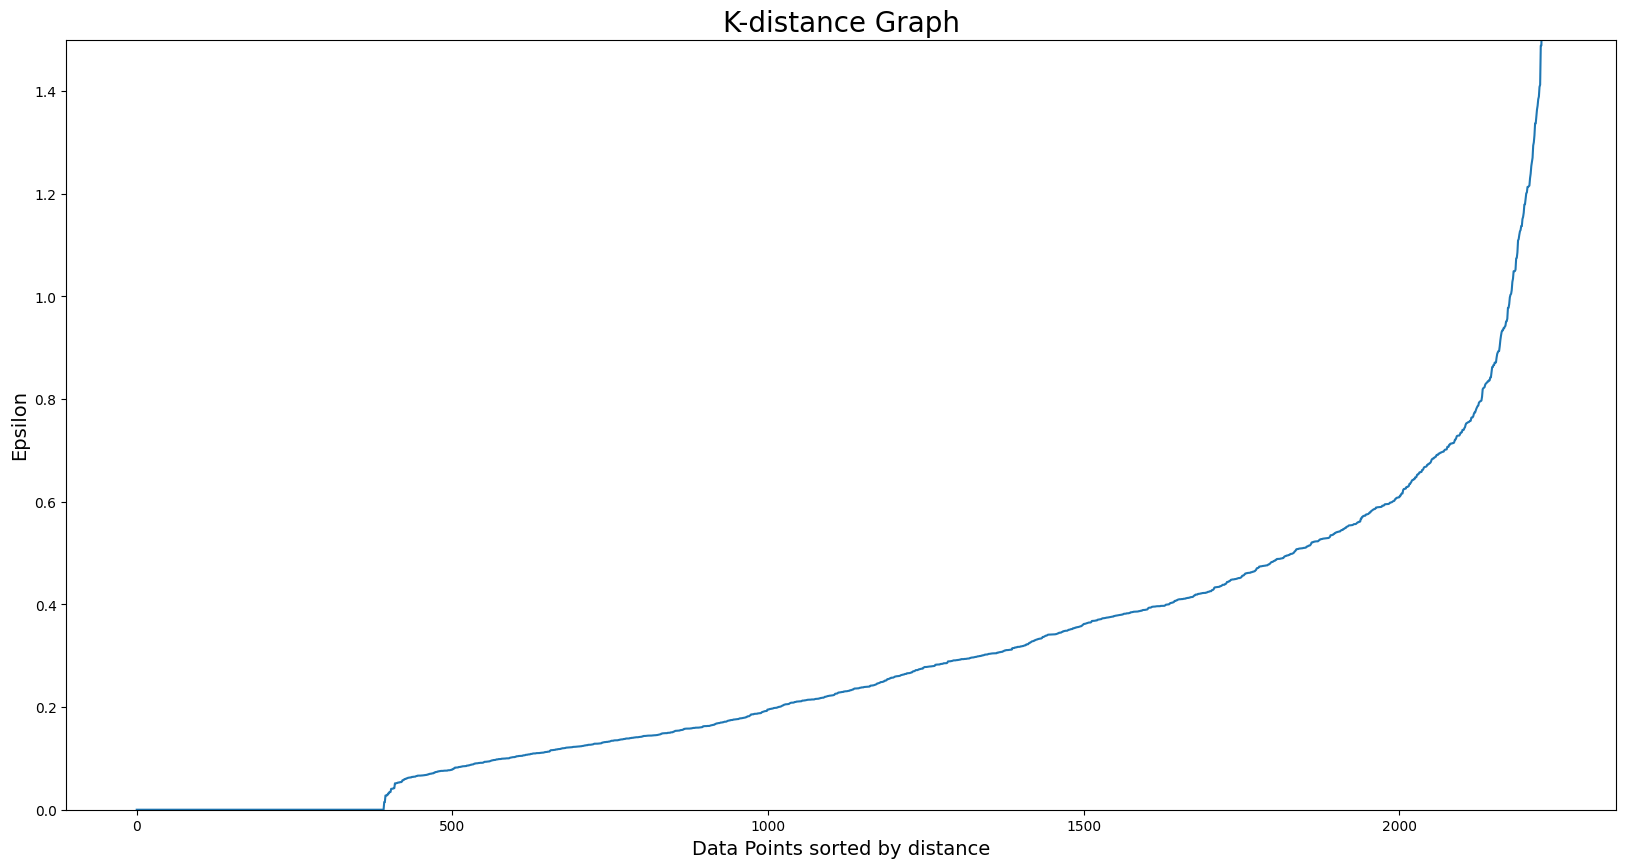

In [115]:
distances = np.sort(distances, axis=0)
distances= distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.ylim(0,1.5)
plt.show()

In [116]:
DBScanModel= DBSCAN(eps=0.7, min_samples=25)

In [117]:
df_dbscan = df.copy()
df_dbscan['cluster']=DBScanModel.fit_predict(df_pca)

In [118]:
df_dbscan['cluster'].value_counts()

cluster
-1    1132
 0    1101
Name: count, dtype: int64

<Axes: >

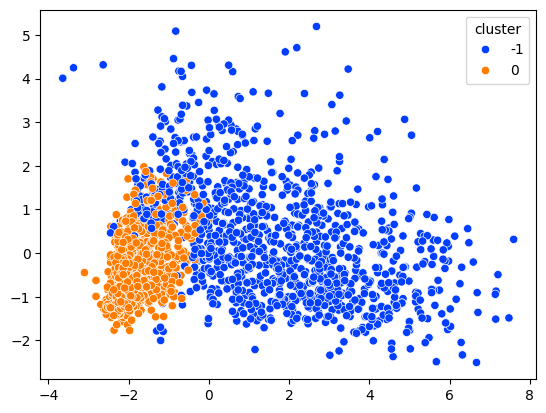

In [129]:
sns.scatterplot(x=df_pca[:,0], y=df_pca[:,2], hue=df_dbscan['cluster'], palette='bright')

# Hierarchical Clustering for Text Data
Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset

In [25]:
import affinegap
from scipy.cluster.hierarchy import linkage, fcluster
from tqdm import tqdm

In [68]:
DATASET_DIR = 'Dataset/books/'
books = pd.read_csv(os.path.join(DATASET_DIR, 'Books.csv'))
books = books.sample(2000).reset_index(drop=True)
display(books.head())

C:\Users\grego\AppData\Local\Temp\ipykernel_46788\4186780914.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv(os.path.join(DATASET_DIR, 'Books.csv'))


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0571132065,The paper men,William Golding,1984,Faber and Faber,http://images.amazon.com/images/P/0571132065.0...,http://images.amazon.com/images/P/0571132065.0...,http://images.amazon.com/images/P/0571132065.0...
1,0671832158,HORROR STY,Speer McNab,1983,Pocket,http://images.amazon.com/images/P/0671832158.0...,http://images.amazon.com/images/P/0671832158.0...,http://images.amazon.com/images/P/0671832158.0...
2,3548364292,Das erfundene Mittelalter. Die grÃ?Â¶Ã?Â?te Ze...,Heribert Illig,2002,Ullstein Tb,http://images.amazon.com/images/P/3548364292.0...,http://images.amazon.com/images/P/3548364292.0...,http://images.amazon.com/images/P/3548364292.0...
3,0072124903,How to Do Everything with Your Palm Handheld,Dave Johnson,2000,McGraw Hill Osborne Media,http://images.amazon.com/images/P/0072124903.0...,http://images.amazon.com/images/P/0072124903.0...,http://images.amazon.com/images/P/0072124903.0...
4,0553252003,The Strong Shall Live,LOUIS L'AMOUR,1985,Bantam,http://images.amazon.com/images/P/0553252003.0...,http://images.amazon.com/images/P/0553252003.0...,http://images.amazon.com/images/P/0553252003.0...


In [74]:
books['text'] = books['Book-Author']+'_'+books['Book-Title']
books.dropna(subset=['text'], inplace=True)
books['text'] = books['text'].str.lower()

In [75]:
books['text']

0                           william golding_the paper men
1                                  speer mcnab_horror sty
2       heribert illig_das erfundene mittelalter. die ...
3       dave johnson_how to do everything with your pa...
4                     louis l'amour_the strong shall live
                              ...                        
1995     christopher buckley_no way to treat a first lady
1996                                       c.j. tosh_bite
1997              mort walker_hi and lois in modern chaos
1998                       adib khan_seasonal adjustments
1999                        danielle steel_vidas cruzadas
Name: text, Length: 2000, dtype: object

In [64]:
def create_distance_matrix(texts):
    print('Creating distance matrix . . .')
    processed_texts = [text for text in texts]
    n = len(processed_texts)
    distance_matrix = np.zeros((n, n))

    for i in tqdm(range(n)):
        for j in range(i + 1, n):
            distance = affinegap.normalizedAffineGapDistance(processed_texts[i], processed_texts[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance # Symmetric matrix

    return distance_matrix

In [31]:
def cluster_texts(texts, threshold=0.5):
    distance_matrix = create_distance_matrix(texts)
    
    # Convert the distance matrix into a condensed distance matrix which is expected by the linkage function
    condensed_matrix = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
    linked = linkage(condensed_matrix, 'average')  # Use average linkage method. Other methods can be tried

    clusters = fcluster(linked, t=threshold, criterion='distance')

    return clusters

In [76]:
threshold = 0.5  # Adjust threshold for desired cluster granularity
cluster_labels = cluster_texts(books['text'], threshold)

for i, text in enumerate(books.loc[:10,'text']):
    print(f"Text {i + 1}: '{text}' - Cluster: {cluster_labels[i]}")

Creating distance matrix . . .


100%|██████████| 2000/2000 [00:35<00:00, 56.39it/s] 


Text 1: 'william golding_the paper men' - Cluster: 1787
Text 2: 'speer mcnab_horror sty' - Cluster: 1258
Text 3: 'heribert illig_das erfundene mittelalter. die grã?â¶ã?â?te zeitfã?â¤lschung der geschichte.' - Cluster: 1085
Text 4: 'dave johnson_how to do everything with your palm handheld' - Cluster: 1619
Text 5: 'louis l'amour_the strong shall live' - Cluster: 843
Text 6: 'francis phelan_guinevere: truth of a legend' - Cluster: 428
Text 7: 'mohamed rasoel_de ondergang van nederland: land der naieve dwazen' - Cluster: 232
Text 8: 'anne c. cain_cooking light superfast suppers: speedy solutions for dinner dilemmas (cooking light)' - Cluster: 1343
Text 9: 'dick francis_for kicks' - Cluster: 1386
Text 10: 'rexanne becnel_the christmas wish' - Cluster: 1882
Text 11: 'lilian darcy_baby bond  (bundles of joy) (silhouette romance, 1390)' - Cluster: 1298


In [77]:
books_cluster = books.copy()
books_cluster['cluster'] = cluster_labels
books_cluster['cluster'].value_counts()

cluster
581     3
1480    2
1839    2
1787    1
865     1
       ..
621     1
1728    1
1613    1
1630    1
1053    1
Name: count, Length: 1996, dtype: int64

In [78]:
books_cluster[books_cluster['cluster']==581]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,text,cluster
51,0553211137,Great Expectations,Charles Dickens,1982,Bantam,http://images.amazon.com/images/P/0553211137.0...,http://images.amazon.com/images/P/0553211137.0...,http://images.amazon.com/images/P/0553211137.0...,charles dickens_great expectations,581
1498,080490068X,Great Expectations,Charles Dickens,1970,Airmont Pub Co,http://images.amazon.com/images/P/080490068X.0...,http://images.amazon.com/images/P/080490068X.0...,http://images.amazon.com/images/P/080490068X.0...,charles dickens_great expectations,581
1939,0451525248,Great Expectations,Charles Dickens,1986,Signet Classics,http://images.amazon.com/images/P/0451525248.0...,http://images.amazon.com/images/P/0451525248.0...,http://images.amazon.com/images/P/0451525248.0...,charles dickens_great expectations,581


In [79]:
books_cluster[books_cluster['Book-Author'].str.contains('Dickens')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,text,cluster
51,0553211137,Great Expectations,Charles Dickens,1982,Bantam,http://images.amazon.com/images/P/0553211137.0...,http://images.amazon.com/images/P/0553211137.0...,http://images.amazon.com/images/P/0553211137.0...,charles dickens_great expectations,581
517,0553213423,Great Expectations (Bantam Classic),Charles Dickens,1982,Bantam,http://images.amazon.com/images/P/0553213423.0...,http://images.amazon.com/images/P/0553213423.0...,http://images.amazon.com/images/P/0553213423.0...,charles dickens_great expectations (bantam cla...,582
1498,080490068X,Great Expectations,Charles Dickens,1970,Airmont Pub Co,http://images.amazon.com/images/P/080490068X.0...,http://images.amazon.com/images/P/080490068X.0...,http://images.amazon.com/images/P/080490068X.0...,charles dickens_great expectations,581
1939,0451525248,Great Expectations,Charles Dickens,1986,Signet Classics,http://images.amazon.com/images/P/0451525248.0...,http://images.amazon.com/images/P/0451525248.0...,http://images.amazon.com/images/P/0451525248.0...,charles dickens_great expectations,581
